# Importamos dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files 
files.upload()

In [ ]:
# importamos el CHURN
churn = pd.read_csv("/content/1btEhxnropj5xquGKyP_MlNf7uIVVBfLL")

In [ ]:
churn.head()

In [ ]:
churn.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

In [ ]:
churn.head()

# Preparamos la data

In [ ]:
X = churn.drop('Exited', axis=1)
y = churn['Exited']

In [ ]:
# importamos la libreria para poder realizar el One Hot Encoding
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Como podemos ver, las columnas que tienen los valores categoricos son la segunda y la tercera (Geography y Gender)

cl = ColumnTransformer(transformers = [('OHE', OneHotEncoder(drop='first'), [1, 2])], remainder='passthrough')
X = cl.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 15)

# AdaBoosting Classifier

In [ ]:
# importamos las librerias necesarias para el modelo

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
# Inicializamos el modelo sobre el cual vamos a realizar el AdaBoost, en este caso un arbol de decision
dt = DecisionTreeClassifier(max_depth=1, random_state=123)

# Inicializamos el Adaboost
adb_clf = AdaBoostClassifier(base_estimator=dt, n_estimators=2000, algorithm='SAMME')

# entrenamos al modelo con los datos de prueba

adb_clf.fit(X_train, y_train)

# predecimos los datos que no conocemos
y_pred = adb_clf.predict(X_test)

In [ ]:
# vamos a ver los resultados del train y test set

val_accuracy = accuracy_score(y_val, y_pred)
train_accuracy = accuracy_score(y_train, adb_clf.predict(X_train))
print('El accuracy de test set es: {:.3f}'.format(val_accuracy))
print('El accuracy de set de prueba es: {:.3f}'.format(train_accuracy))

In [ ]:
adb_clf.predict_proba(X_test)

## Prediccion cambiando la cantidad de arboles

In [ ]:
# Vamos a probar con diferentes tamanos de arboles
# Para ello vamos a utilizar la funcion np.arange.

n_estimators = np.arange(50, 801, 50)
n_estimators

In [ ]:
# Creamos un diccionario para almacenar el accuracy en funcion a la cantidad de arboles

acc_gb = {'n_estimators': [], 'acc_test': [], 'acc_train': []}

In [ ]:
for n in n_estimators:

  dt = DecisionTreeClassifier(max_depth=1,
                              random_state=123)

  model = AdaBoostClassifier(base_estimator=dt, n_estimators=n)  

  model.fit(X_train, y_train)
  acc_gb['n_estimators'].append(n)
  acc_gb['acc_test'].append(accuracy_score(y_test, model.predict(X_test)))
  acc_gb['acc_train'].append(accuracy_score(y_train, model.predict(X_train)))

In [ ]:
pd.DataFrame(acc_gb)

## Prediccion cambiando el max_depth

In [ ]:
# Vamos a probar con diferentes niveles
# Para ello vamos a utilizar la funcion np.arange.

max_depth = np.arange(1, 10)
max_depth

In [ ]:
# Creamos un diccionario para almacenar el accuracy en funcion a la cantidad de arboles

acc_md = {'Max_depth': [], 'acc_test': [], 'acc_train': []}

In [ ]:
for md in max_depth:

  dt = DecisionTreeClassifier(max_depth=md, random_state=123)

  model = AdaBoostClassifier(n_estimators=300)
  

  model.fit(X_train, y_train)
  acc_md['Max_depth'].append(md)
  acc_md['acc_test'].append(accuracy_score(y_test, model.predict(X_test)))
  acc_md['acc_train'].append(accuracy_score(y_train, model.predict(X_train)))

In [ ]:
pd.DataFrame(acc_md)

## Veamos el resultado con la matriz de beneficio

In [ ]:
# vamos a utilizar 500 estimadores, max_depth=1, max_features=1

dt = DecisionTreeClassifier(min_samples_leaf=0.12, random_state=123)

adaboost = AdaBoostClassifier(n_estimators=600)

adaboost.fit(X_train, y_train)

In [ ]:
sns.set_style('whitegrid')

ada_imp = pd.Series(adaboost.feature_importances_, index=['Geo_f', 'Geo_g', 'Gender', 'CreditScore','Age', 'Ternure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'])

ada_imp.sort_values().plot(kind='barh')

## Umbral = 0.5

### Prediccion umbral

In [ ]:
# por defecto, el metodo predict realiza la clasificacion de la probabilidad con un umbral de 0.5

y_pred = adaboost.predict(X_test)

In [ ]:
# calculamos el accuracy del modelo

accuracy_score(y_test, y_pred)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
# descomponemos la matriz de confusion en los cuatro posibles resultados

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [ ]:
# Revisamos el calculo del accuracy con los datos que nos entrega la matriz

(tn + tp) / (tn + fp + fn + tp)

In [ ]:
p_tp = tp / (tn + fp + fn + tp)
p_fn = fn / (tn + fp + fn + tp)
p_tn = tn / (tn + fp + fn + tp)
p_fp = fp / (tn + fp + fn + tp)

In [ ]:
p_tp

In [ ]:
p_fn

In [ ]:
p_tn

In [ ]:
p_fp

### Matriz de beneficio 

In [ ]:
# vamos a definir los beneficios/costos asociados a cada alternativa

b_tp = 750
b_tn = 100
c_fp = -200
c_fn = -950

In [ ]:
valor_esperado = p_tp * b_tp + p_fn * c_fn + p_tn * b_tn + p_fp * c_fp
valor_esperado

## Cambio de umbral

### Prediccion umbral

In [ ]:
# adaboost requiere una calibracion de probabilidad para poder especializarlo

from sklearn.calibration import CalibratedClassifierCV

ada_calib = CalibratedClassifierCV(adaboost, cv=2, method='isotonic')
ada_calib.fit(X_train, y_train)

In [ ]:
# vamos a tener que especializar la probabilidad en el valor que deseamos, en este caso 0.2

y_pred = ada_calib.predict_proba(X_test)[:, 1] > 0.2

In [ ]:
ada_calib.predict_proba(X_test)

In [ ]:
# calculamos el accuracy del modelo

accuracy_score(y_test, y_pred)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
# descomponemos la matriz de confusion en los cuatro posibles resultados

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [ ]:
p_tp = tp / (tn + fp + fn + tp)
p_fn = fn / (tn + fp + fn + tp)
p_tn = tn / (tn + fp + fn + tp)
p_fp = fp / (tn + fp + fn + tp)

### Matriz de beneficio

In [ ]:
# como ya tenemos todas las demas matrices construidas, solo nos resta volver a realizar el calculo del valor esperado

valor_esperado = p_tp * b_tp + p_fn * c_fn + p_tn * b_tn + p_fp * c_fp
valor_esperado

# AdaBoosting Regression

In [ ]:
# para este ejercicio vamos a volver a utilizar el Dataset de Properatti

df = pd.read_csv('/content/drive/My Drive/4- Data Science/Clases UBA/Datasets/Aptos_BsAs_Todos.csv')

In [ ]:
df.head()

In [ ]:
df.describe()

In [ ]:
df.info()

In [ ]:
# preparacion de la data

X = df.drop('precio', axis=1)
y = df['precio']

# importamos la libreria para poder realizar el One Hot Encoding
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Como podemos ver, las columnas que tienen los valores categoricos son la segunda y la tercera (Geography y Gender)


cl = ColumnTransformer(transformers = [('OHE', OneHotEncoder(drop='first'), [0, 1]),
                                       ('scaler', StandardScaler(), [4])], remainder='passthrough')

X = cl.fit_transform(X)

# separamos la muestra en entrenamiento y validacion
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 15)

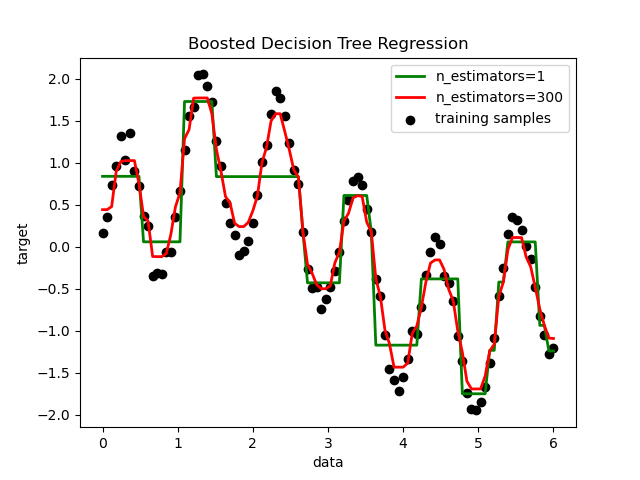

In [ ]:
# ahora importamos la libreria de AdaBoosting Regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression

dt = DecisionTreeRegressor(max_depth=20, random_state=123)

# inicializamos el modelo
reg = AdaBoostRegressor(base_estimator=dt, n_estimators=7)

# entrenamos el modelo
reg.fit(X_train, y_train)

In [ ]:
test_accuracy = reg.score(X_test, y_test)
train_accuracy = reg.score(X_train, y_train)
print('El accuracy de test set es: {:.3f}'.format(test_accuracy))
print('El accuracy de test de prueba es: {:.3f}'.format(train_accuracy))

# Actividades propuestas

1- Armar 2 bucles for anidados para testear diferentes hiperparametros en AdaBoosting (probar con max_depth y n_estimators)


2- Buscar la mejor combinacion de hiperparametros que maximice la precision en el churn.

3- Probar el AdaBoostRegressor con diferentes base estimators, y encontrar el que mejor accuracy ofrece para el problema